# Tutorial on single-cell trajectory alignment using Genes2Genes

Genes2Genes (G2G) aims to guide downstream comparative analysis of single-cell reference and query systems along any axis of progression (e.g. differentiation pseudotime, disease/treatment response pseudotime etc.). This notebook describes how we can use G2G framework to infer and analyse gene-level trajectory alignments between a given reference and query dataset.

In this tutorial, we are going to compare trajectories between two treatment groups (PAM and LPS) of mouse bone marrow-derived dendritic cells from Shalek et al (2014). The single cell datasets and their pseudotime estimates were downloaded from https://github.com/shenorrLab/cellAlign (Alpert et al 2018) and packaged into adata objects. There are 2 gene modules: global (core antiviral module) and local (peaked inflammatory module) considered by Alpert et al (2018), and we use the local module as an example comparison.

- **Brief:** 两个标准化后且有时序信息的h5ad的共有hvgs做时序轨迹比较
- **Log:** 250826

In [2]:
import os
import anndata
import numpy as np
import pandas as pd
import seaborn as sb
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

from genes2genes import Main
from genes2genes import ClusterUtils
from genes2genes import TimeSeriesPreprocessor
from genes2genes import PathwayAnalyser
from genes2genes import VisualUtils

Matplotlib created a temporary cache directory at /tmp/matplotlib-8b10dkq1 because the default path (/home/stereonote/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


### Load anndata reference and query objects

Make sure that each adata object has: <br>
(1) log normalized gene expression in `adata.X` <br>
(2) pseudotime estimates in `adata.obs['time']`

In [3]:
print(os.getcwd())

/data/work/cotton/genes2genes/TEST3


In [4]:
adata_ref = anndata.read_h5ad(h5ad_ref) # Reference dataset
adata_query = anndata.read_h5ad(h5ad_query) # Query dataset
prefix_ref = os.path.splitext(os.path.basename(h5ad_ref))[0]
prefix_query = os.path.splitext(os.path.basename(h5ad_query))[0]

In [5]:
print(adata_ref); print(adata_query)

AnnData object with n_obs × n_vars = 537 × 27363
    obs: 'nCount_RNA', 'nFeature_RNA', 'new_index', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_genes', 'doublet_score', 'leiden', 'leiden_res_0.20', 'leiden_res_0.80', 'leiden_res_1.00', 'leiden_res_1.30', 'leiden_res_1.60', 'leiden_res_2.00', 'RNA_snn_res.0.5', 'seurat_clusters', 'palantir_pseudotime'
    var: 'new_index', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    uns: 'RNA_snn_res.0.5_colors', 'hvg', 'log1p', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'X_xp

In [6]:
adata_ref.obs['time'] = adata_ref.obs[pseudotime_key]
adata_query.obs['time'] = adata_query.obs[pseudotime_key]

## 1. Preparing data for alignment 

### Pseudotime range check
Check whether the current range of pseudotime values are between 0 and 1. If not, run min max normalization. 

In [7]:
print(min(adata_ref.obs['time']), max(adata_ref.obs['time']))
print(min(adata_query.obs['time']), max(adata_query.obs['time']))

# # uncomment below if the pseudotime range is not [0,1] for any of the objects 
# adata_ref.obs['time'] = TimeSeriesPreprocessor.Utils.minmax_normalise(np.asarray(adata_ref.obs['time']))
# adata_query.obs['time'] = TimeSeriesPreprocessor.Utils.minmax_normalise(np.asarray(adata_query.obs['time']))

0.0 1.0
0.0 1.0


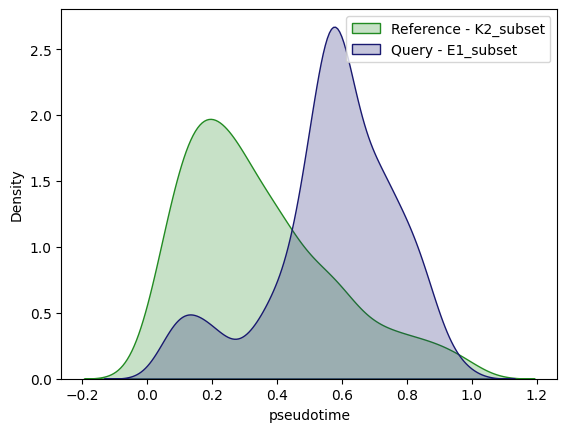

In [8]:
# Visualize the pseudotime distributions
sb.kdeplot(adata_ref.obs['time'], fill=True, label=f'Reference - {prefix_ref}', color='forestgreen') 
sb.kdeplot(adata_query.obs['time'], fill=True, label=f'Query - {prefix_query}', color='midnightblue'); 
plt.xlabel('pseudotime'); plt.legend()
plt.savefig(f'pseudotime_{prefix_ref}_vs_{prefix_query}.pdf', bbox_inches='tight')
plt.show()
plt.close('all')

### Determine the number of discrete pseudotime points to align

We can use optbinning package (https://gnpalencia.org/optbinning/installation.html) to get a heuristic estimate about the number of discrete time points to consider by running below on each dataset.<br>  **Note:** Run `pip install optbinning` if this is not already installed. 

In [9]:
from optbinning import ContinuousOptimalBinning

x = np.asarray(adata_ref.obs.time)
optb = ContinuousOptimalBinning(name='pseudotime', dtype="numerical")
optb.fit(x, x)
print(len(optb.splits))
n_bins = len(optb.splits) # Bins of Reference as a standard

x = np.asarray(adata_query.obs.time)
optb = ContinuousOptimalBinning(name='pseudotime', dtype="numerical")
optb.fit(x, x)
print(len(optb.splits))

(CVXPY) Aug 26 01:34:13 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Aug 26 01:34:13 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
15
15


Accordingly, we go with `n_bins=14`

### Define which cell type annotations and color scheme to use for visualization purposes

`annotation_colname` and `joint_cmap`

In [10]:
# # define annotation column name in the adata obs
# annotation_colname = 'leiden_res_0.50' 
# # adata_ref.obs[annotation_colname] = [x.split('_')[1] for x in adata_ref.obs_names] 
# # adata_query.obs[annotation_colname] = [x.split('_')[1] for x in adata_query.obs_names] 

# define the joint colormap to use for both reference and query
joint_order = adata_ref.obs[annotation_colname].unique()
colors = np.array(sb.color_palette('colorblind'))[range(len(joint_order))]
joint_cmap1 = dict(zip(joint_order, colors))

joint_order = adata_query.obs[annotation_colname].unique()
colors = np.array(sb.color_palette('colorblind'))[range(len(joint_order))]
joint_cmap2 = dict(zip(joint_order, colors))

Inspect the cell type compositions around each discrete pseudotime point (x-axis) to see if it reasonably represents the entire trajectory of interest. 

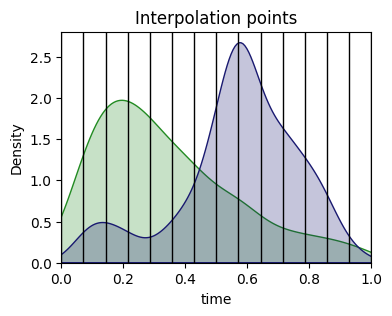

In [11]:
VisualUtils.plot_pseudotime_dists_with_interpolation_points(adata_ref, adata_query, n_bins)
plt.savefig(f'pseudotime_point_{prefix_ref}_vs_{prefix_query}.pdf', bbox_inches='tight')
plt.show()
plt.close('all')

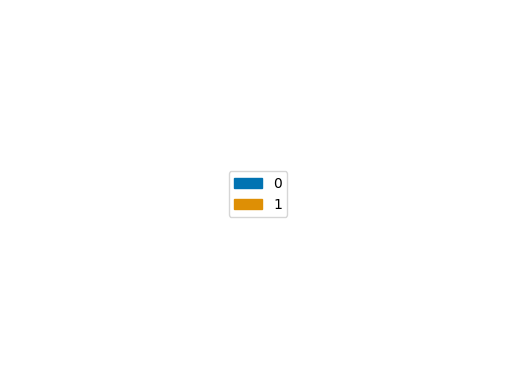

In [12]:
VisualUtils.plot_any_legend(joint_cmap1)
plt.savefig(f'pseudotime_{prefix_ref}.pdf', bbox_inches='tight')
plt.show()
plt.close('all')

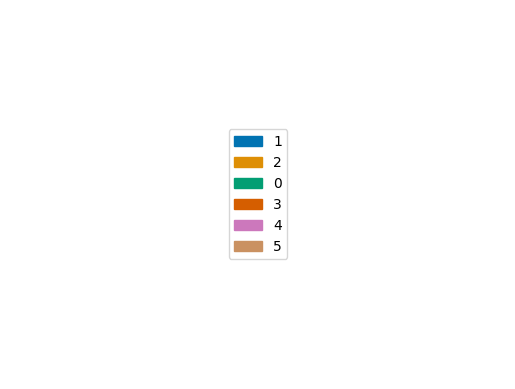

In [13]:
plt.close('all')
VisualUtils.plot_any_legend(joint_cmap2)
plt.savefig(f'pseudotime_{prefix_query}.pdf', bbox_inches='tight')
plt.show()
plt.close('all')

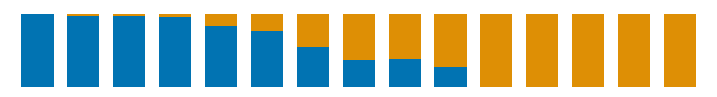

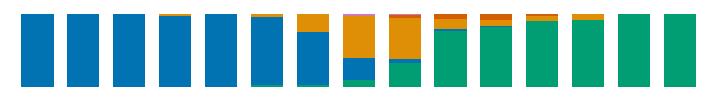

In [14]:
VisualUtils.plot_celltype_barplot(adata_ref, n_bins, annotation_colname, joint_cmap1)
plt.savefig(f'pseudotime_{prefix_ref}_2.pdf', bbox_inches='tight')
plt.show()
plt.close('all')
VisualUtils.plot_celltype_barplot(adata_query, n_bins, annotation_colname, joint_cmap2)
plt.savefig(f'pseudotime_{prefix_query}_2.pdf', bbox_inches='tight')
plt.show()
plt.close('all')

## 2. G2G trajectory alignment

**Example gene sets to align:** all human transcription factors, all highly variable genes, lineage-specific genes of interest, a specific pathway gene set etc.

In [ ]:
# define the gene list to align 必须两者都存在的基因
# define the gene list to align 必须两者都存在的基因
if alignment_genes == "hvg":
    print("# Using intersection hvgs...")
    hv_ref   = adata_ref.var_names[adata_ref.var['highly_variable']]
    hv_query = adata_query.var_names[adata_query.var['highly_variable']]
else: 
    print("# Using intersection genes...")
    hv_ref   = adata_ref.var_names
    hv_query = adata_query.var_names


common_genes = hv_ref.intersection(hv_query)
gene_list = common_genes

print(len(gene_list),'genes')

6583 genes


### Aligning all genes

In [16]:
aligner = Main.RefQueryAligner(adata_ref, adata_query, gene_list, n_bins) #
aligner.align_all_pairs()

Genes2Genes (v0.2.0)
Dynamic programming alignment of gene pseudotime trajectories using a bayesian information-theoretic framework
Interpolator initialization completed
Aligner initialised to align trajectories of 537 reference cells & 1721 query cells in terms of 6583 genes
Running gene-level alignment: 🧬


100%|██████████| 6583/6583 [38:05<00:00,  2.88it/s]  

Alignment completed! ✅


To access gene-level alignments, use the dictionary: `aligner.results_map` which carries all gene alignment objects. <br>
e.g. `aligner.results_map['TNF']`

In [17]:
# gene_obj = aligner.results_map['Ga01g00047']
# alignment_str = gene_obj.alignment_str
# print(alignment_str)
# print(VisualUtils.color_al_str(alignment_str)) 
# print()
# print(gene_obj.al_visual)
# # Alignment landscape of costs (Note: dashed black path is the optimal alignment)
# gene_obj.landscape_obj.plot_alignment_landscape()
# # Note: optimal path diagonals represent matches; 
# # vertical and horizontal paths could represent either warp matches or indels (mismatches)

Visualise alignment in terms of both the cell-type compositions, as well as actual and interpolated gene expression. <br>
Top left: Visualise alignmebt in terms of cell-type composition <br>
Bottom left: the mean trends and interpolated distributions of gene expression along pseudotime. <br>
Bottom right: the actual gene expression values along pseudotime. 

In [18]:
# VisualUtils.plotTimeSeries('Ga01g00047', aligner, plot_cells=True)

In [19]:
# VisualUtils.show_gene_alignment('TNF', aligner, adata_ref, adata_query, annotation_colname, joint_cmap)

# # Visualise gene-level alignment in terms of only the cell-type composition 
# # VisualUtils.visualize_gene_alignment(aligner.results_map['TNF'], adata_ref, adata_query, annotation_colname, cmap=joint_cmap)

### Aggregate (average) cell-level alignment across all aligned genes

This is an average alignment which is sampled based on the frequency distribution of alignment states between each pair of reference and query timepoints. The heatmap value gives the number of genes where the corresponding timepoints have been matched. Note: There can still be different patterns of alignment across these genes (100% mismatching, 100% matching, early mismatching, late mismatching gene groups) which we will find by clustering in the next section. 

Average Alignment:  MMMMMMVVVDVVVDVVDVDDDDDD (cell-level)
% similarity: 62.5


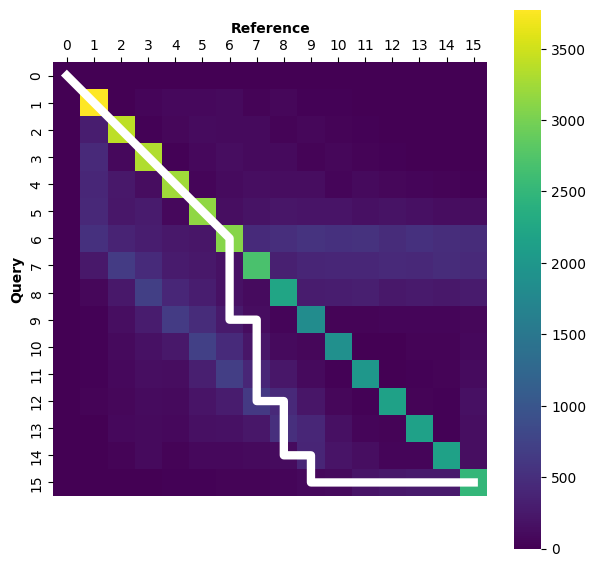

In [20]:
aligner.get_aggregate_alignment() 
plt.savefig(f'aggregate_alignment_{prefix_ref}_vs_{prefix_query}.pdf', bbox_inches='tight')
# Note: White path represents the average alignment path where diagonals represent matches; 
# vertical and horizontal paths could represent either warp matches or indels (mismatches)

In [21]:
plt.close('all')

## 3. Analysing gene-level alignments

Ranking genes based on their alignment similarities

Mean alignment similarity percentage (matched %): 
60.519999999999996 %


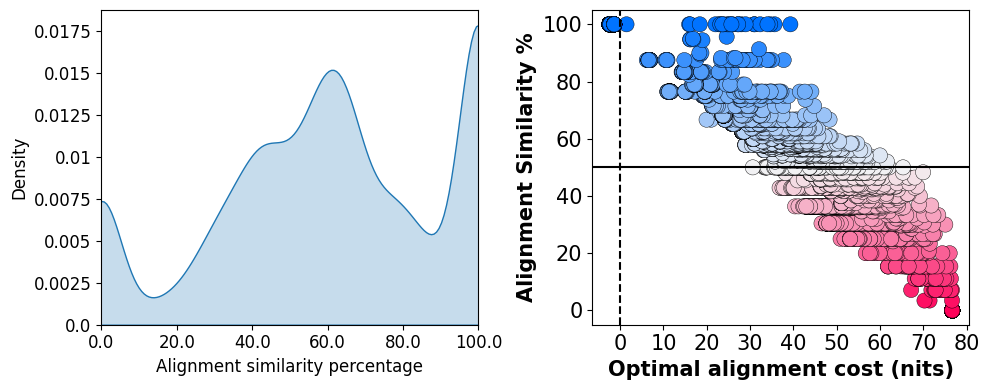

In [22]:
df = aligner.get_stat_df() # ordered genes according to alignment similarity statistics 
plt.savefig(f'ranking_genes_{prefix_ref}_vs_{prefix_query}.pdf', bbox_inches='tight')

In [23]:
plt.close('all')

In [24]:
print(df)
print('Ten genes of the lowest similarity: ')
print(df['Gene'][1:10])
df.to_csv(f"ranking_genes__{prefix_ref}_vs_{prefix_query}.csv", index=False)

            Gene alignment_similarity_percentage opt_alignment_cost l2fc  \
430   Ga01g02511                             0.0          76.678455 -inf   
658   Ga14g01058                             0.0          76.678455 -inf   
1137  Ga03g00652                             0.0          76.678455 -inf   
1173  Ga03g00447                             0.0          76.678455 -inf   
1281  Ga04g01820                             0.0          76.678455 -inf   
...          ...                             ...                ...  ...   
5473  Ga12g01637                             1.0          -1.370787  NaN   
5600  Ga12g00977                             1.0          -1.370787  NaN   
5783  Ga05g00518                             1.0          -1.370787  NaN   
6330  Ga13g01221                             1.0          -1.370787  NaN   
6387  Ga13g01555                             1.0          -1.370787  NaN   

      color abs_l2fc  
430     red      inf  
658     red      inf  
1137    red      i

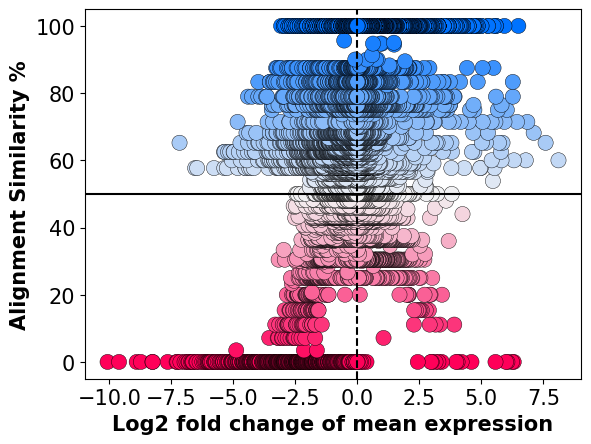

In [25]:
VisualUtils.plot_alignmentSim_vs_l2fc(df)
plt.savefig(f'ranking_genes_log2_{prefix_ref}_vs_{prefix_query}.pdf', bbox_inches='tight')

In [26]:
plt.close('all')

A ranked list of genes based on their first match occurrence 

In [27]:
earliest_match_sorted_genes_list = aligner.show_ordered_alignments()

In the order of the first match occurrence along pseudotime
Gene        Alignment
----------  ------------------------------
Ga01g00129  IIIDIDIDIDIIIIIIIIIDDDDDDDDDDD
Ga01g00047  IIIDIDIDIDIIIIIIIIIDDDDDDDDDDD
Ga01g00095  IIIDIDIDIDIIIIIIIIIDDDDDDDDDDD
Ga01g00162  IIIDIDIDIDIIIIIIIIIDDDDDDDDDDD
Ga01g00241  IIIDIDIDIDIIIIIIIIIDDDDDDDDDDD
Ga01g00298  IIIDIDIDIDIIIIIIIIIDDDDDDDDDDD
Ga01g00337  IIIDIDIDIDIIIIIIIIIDDDDDDDDDDD
Ga01g00628  IIIDIDIDIDIIIIIIIIIDDDDDDDDDDD
Ga01g00729  IIIDIDIDIDIIIIIIIIIDDDDDDDDDDD
Ga01g00776  IIIDIDIDIDIIIIIIIIIDDDDDDDDDDD
Ga01g00942  IIIDIDIDIDIIIIIIIIIDDDDDDDDDDD
Ga01g01059  IIIDIDIDIDIIIIIIIIIDDDDDDDDDDD
Ga01g01114  IIIDIDIDIDIIIIIIIIIDDDDDDDDDDD
Ga01g01116  IIIDIDIDIDIIIIIIIIIDDDDDDDDDDD
Ga01g01117  IIIDIDIDIDIIIIIIIIIDDDDDDDDDDD
Ga01g01122  IIIDIDIDIDIIIIIIIIIDDDDDDDDDDD
Ga01g01207  IIIDIDIDIDIIIIIIIIIDDDDDDDDDDD
Ga01g01480  IIIDIDIDIDIIIIIIIIIDDDDDDDDDDD
Ga02g00973  IIIDIDIDIDIIIIIIIIIDDDDDDDDDDD
Ga02g00971  IIIDIDIDIDIIIIIIIIIDDDDDDDDDDD
Ga02g01053  III

## Gene-set overrepresentation analysis on the top dissimilar genes 

Checking top dissimilar genes, i.e, only <=30% similarity along pseudotime

Processing gene: Ga01g02511
IIIDIDIDIDIIIIIIIIIDDDDDDDDDDD
IIIDIDIDIDIIIIIIIIIDDDDDDDDDDD

012345678901234567890123456789 Alignment index 
   0 1 2 3         45678901234 Reference index
---*-*-*-*---------***********
***-*-*-*-*********-----------
012 3 4 5 678901234            Query index
IIIDIDIDIDIIIIIIIIIDDDDDDDDDDD 5-state string 


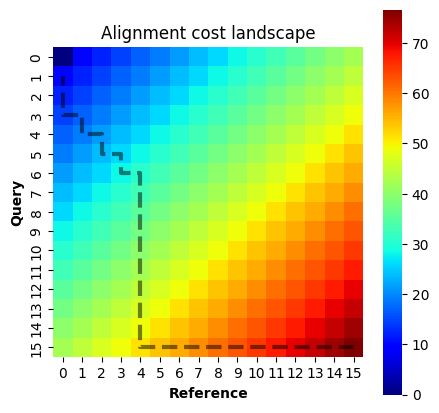

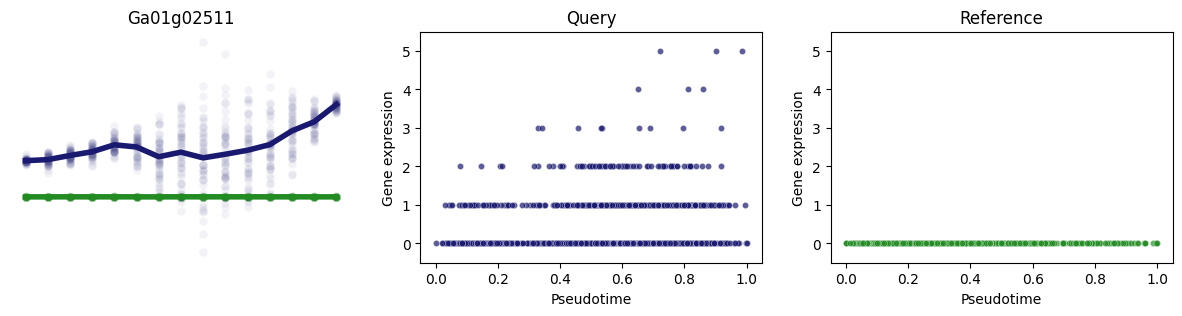

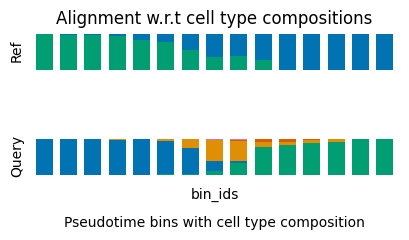

Processing gene: Ga14g01058
IIIDIDIDIDIIIIIIIIIDDDDDDDDDDD
IIIDIDIDIDIIIIIIIIIDDDDDDDDDDD

012345678901234567890123456789 Alignment index 
   0 1 2 3         45678901234 Reference index
---*-*-*-*---------***********
***-*-*-*-*********-----------
012 3 4 5 678901234            Query index
IIIDIDIDIDIIIIIIIIIDDDDDDDDDDD 5-state string 


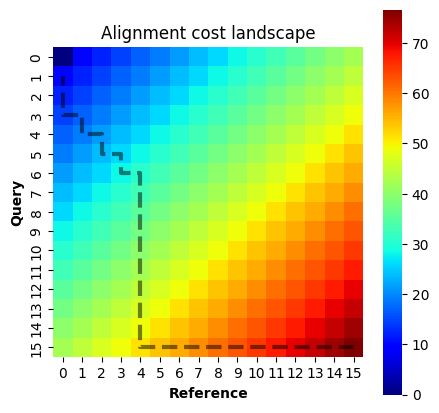

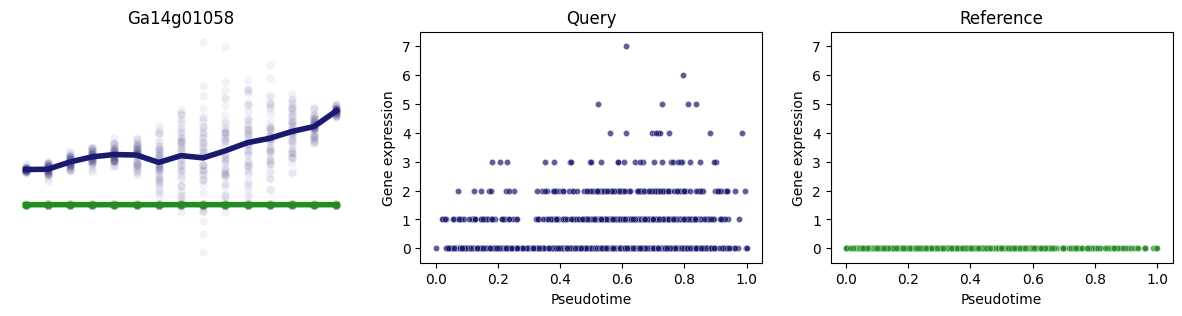

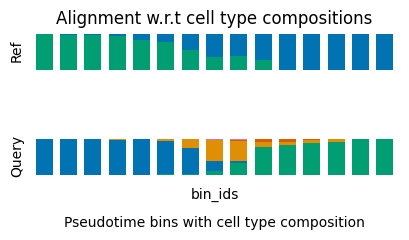

Processing gene: Ga03g00652
IIIDIDIDIDIIIIIIIIIDDDDDDDDDDD
IIIDIDIDIDIIIIIIIIIDDDDDDDDDDD

012345678901234567890123456789 Alignment index 
   0 1 2 3         45678901234 Reference index
---*-*-*-*---------***********
***-*-*-*-*********-----------
012 3 4 5 678901234            Query index
IIIDIDIDIDIIIIIIIIIDDDDDDDDDDD 5-state string 


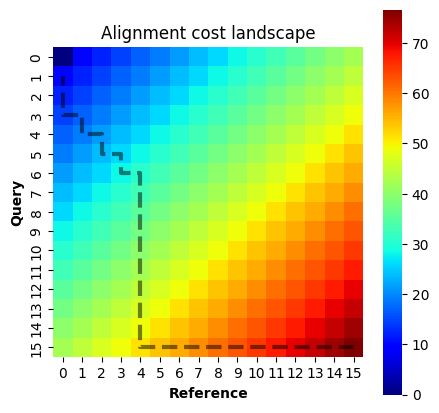

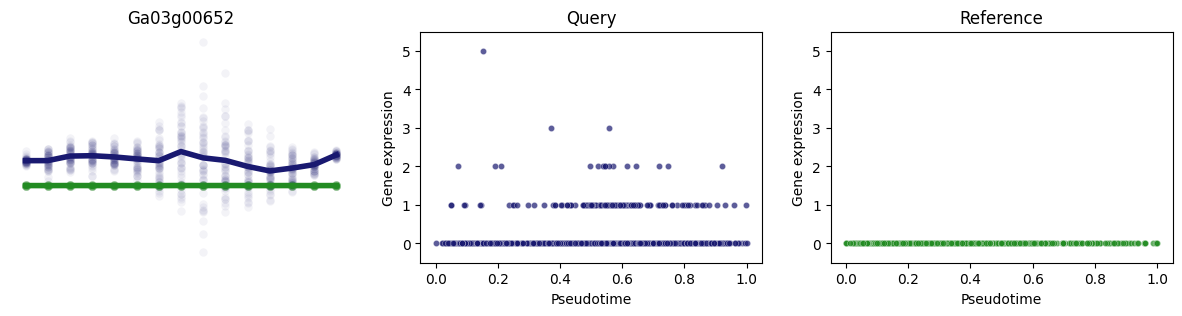

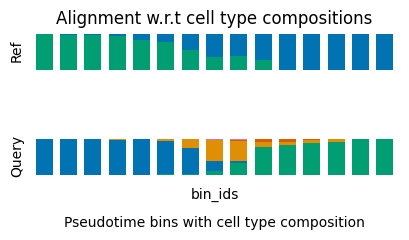

Processing gene: Ga03g00447
IIIDIDIDIDIIIIIIIIIDDDDDDDDDDD
IIIDIDIDIDIIIIIIIIIDDDDDDDDDDD

012345678901234567890123456789 Alignment index 
   0 1 2 3         45678901234 Reference index
---*-*-*-*---------***********
***-*-*-*-*********-----------
012 3 4 5 678901234            Query index
IIIDIDIDIDIIIIIIIIIDDDDDDDDDDD 5-state string 


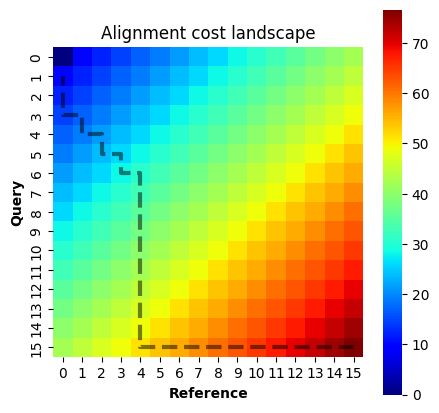

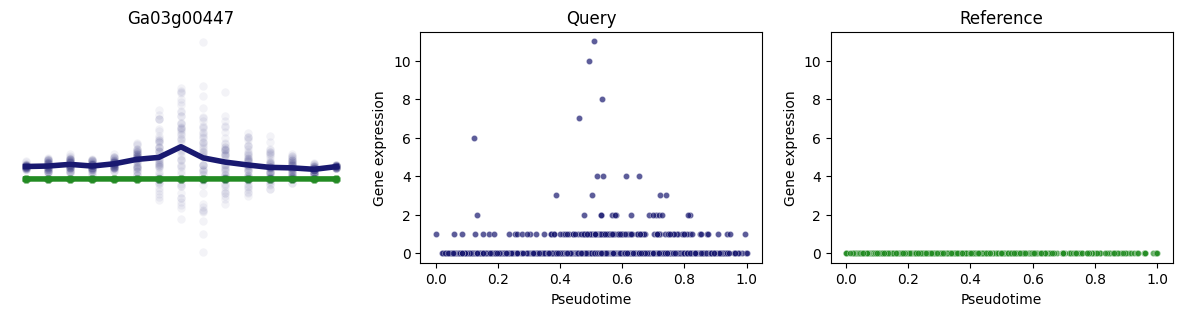

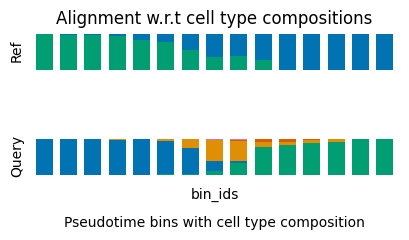

Processing gene: Ga04g01820
IIIDIDIDIDIIIIIIIIIDDDDDDDDDDD
IIIDIDIDIDIIIIIIIIIDDDDDDDDDDD

012345678901234567890123456789 Alignment index 
   0 1 2 3         45678901234 Reference index
---*-*-*-*---------***********
***-*-*-*-*********-----------
012 3 4 5 678901234            Query index
IIIDIDIDIDIIIIIIIIIDDDDDDDDDDD 5-state string 


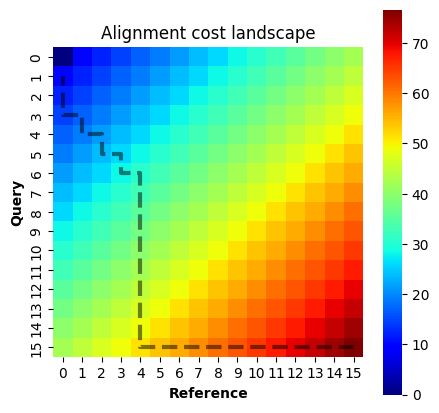

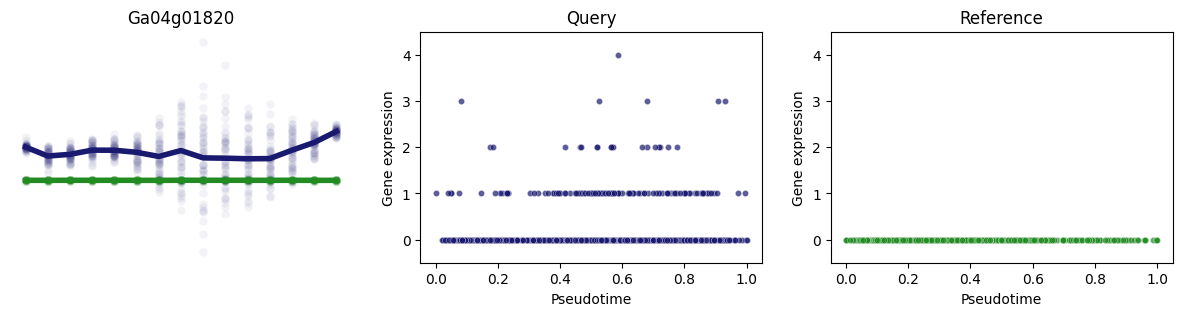

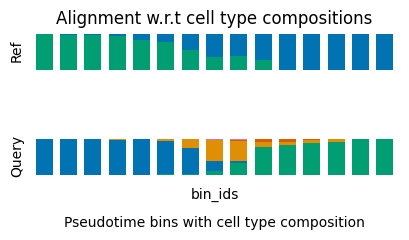

Processing gene: Ga04g01317
IIIDIDIDIDIIIIIIIIIDDDDDDDDDDD
IIIDIDIDIDIIIIIIIIIDDDDDDDDDDD

012345678901234567890123456789 Alignment index 
   0 1 2 3         45678901234 Reference index
---*-*-*-*---------***********
***-*-*-*-*********-----------
012 3 4 5 678901234            Query index
IIIDIDIDIDIIIIIIIIIDDDDDDDDDDD 5-state string 


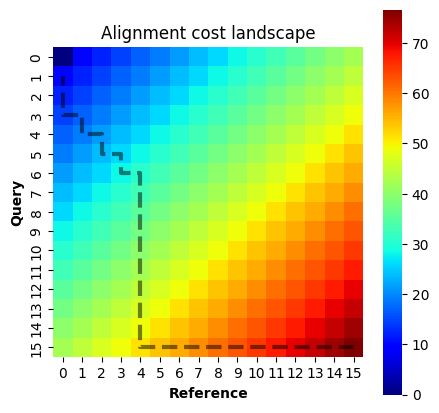

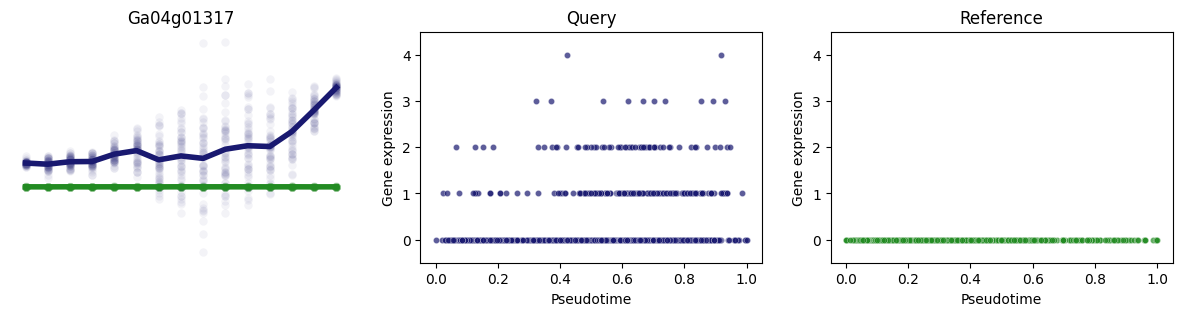

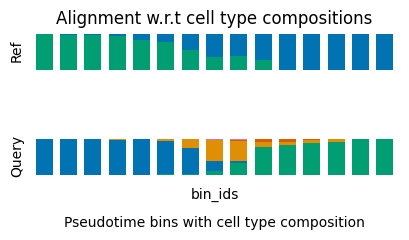

Processing gene: Ga12g01951
IIIDIDIDIDIIIIIIIIIDDDDDDDDDDD
IIIDIDIDIDIIIIIIIIIDDDDDDDDDDD

012345678901234567890123456789 Alignment index 
   0 1 2 3         45678901234 Reference index
---*-*-*-*---------***********
***-*-*-*-*********-----------
012 3 4 5 678901234            Query index
IIIDIDIDIDIIIIIIIIIDDDDDDDDDDD 5-state string 


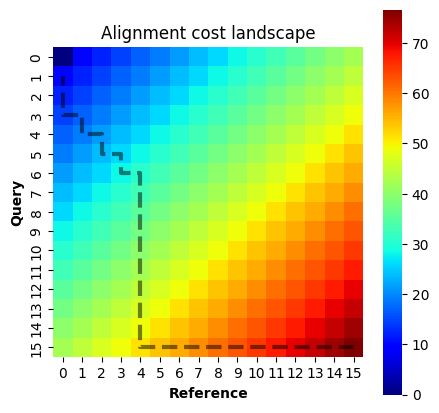

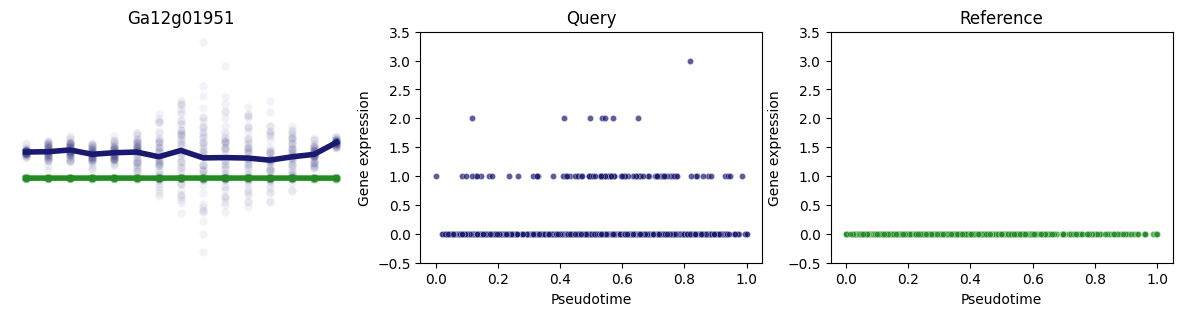

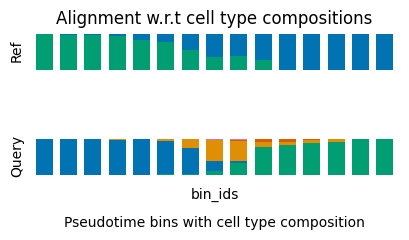

Processing gene: Ga04g00697
IIIDIDIDIDIIIIIIIIIDDDDDDDDDDD
IIIDIDIDIDIIIIIIIIIDDDDDDDDDDD

012345678901234567890123456789 Alignment index 
   0 1 2 3         45678901234 Reference index
---*-*-*-*---------***********
***-*-*-*-*********-----------
012 3 4 5 678901234            Query index
IIIDIDIDIDIIIIIIIIIDDDDDDDDDDD 5-state string 


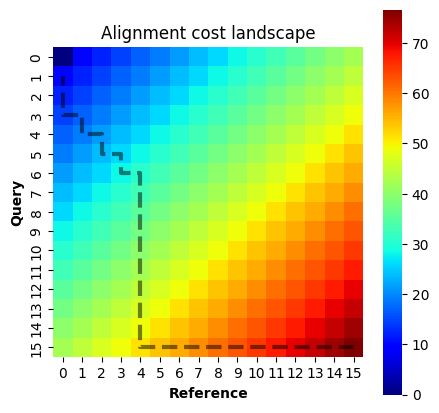

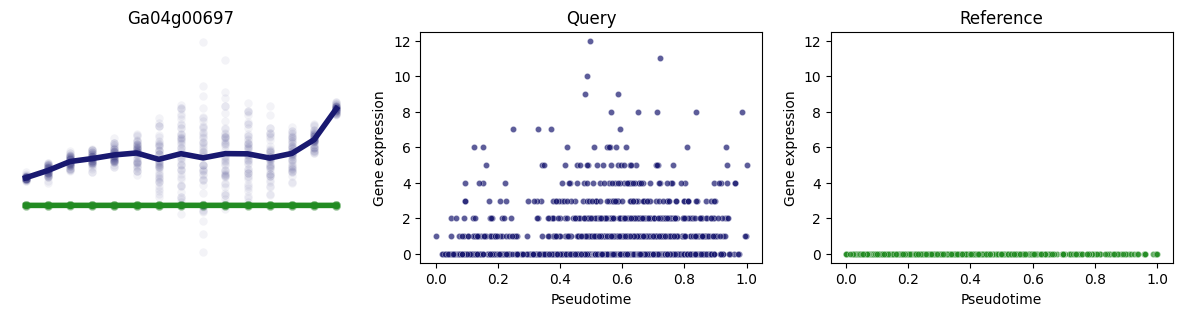

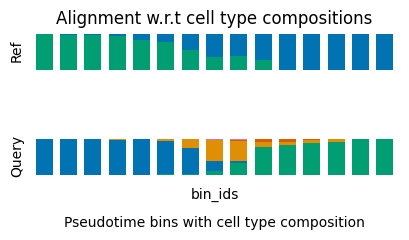

Processing gene: Ga05g02172
IIIDIDIDIDIIIIIIIIIDDDDDDDDDDD
IIIDIDIDIDIIIIIIIIIDDDDDDDDDDD

012345678901234567890123456789 Alignment index 
   0 1 2 3         45678901234 Reference index
---*-*-*-*---------***********
***-*-*-*-*********-----------
012 3 4 5 678901234            Query index
IIIDIDIDIDIIIIIIIIIDDDDDDDDDDD 5-state string 


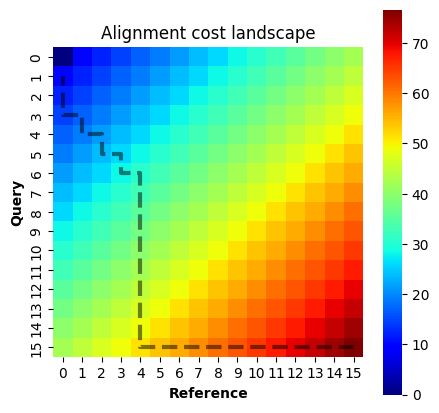

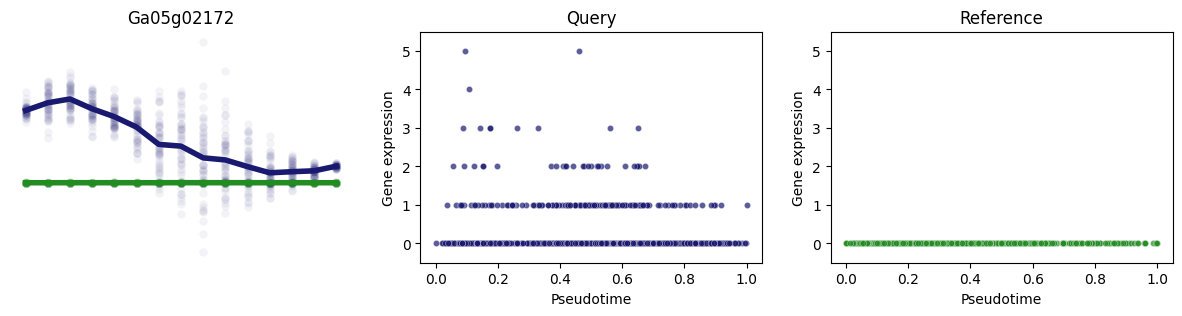

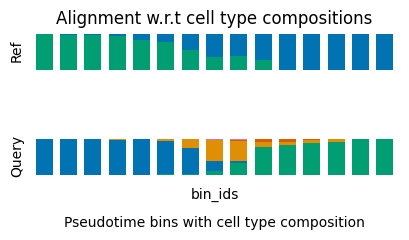

Processing gene: Ga05g02544
IIIDIDIDIDIIIIIIIIIDDDDDDDDDDD
IIIDIDIDIDIIIIIIIIIDDDDDDDDDDD

012345678901234567890123456789 Alignment index 
   0 1 2 3         45678901234 Reference index
---*-*-*-*---------***********
***-*-*-*-*********-----------
012 3 4 5 678901234            Query index
IIIDIDIDIDIIIIIIIIIDDDDDDDDDDD 5-state string 


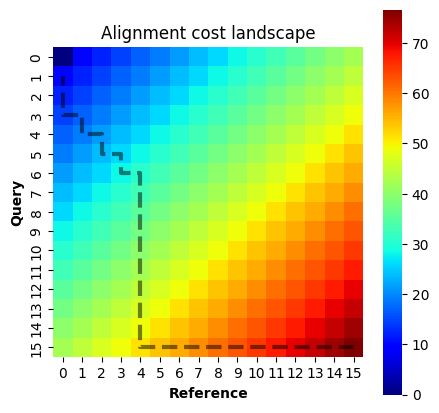

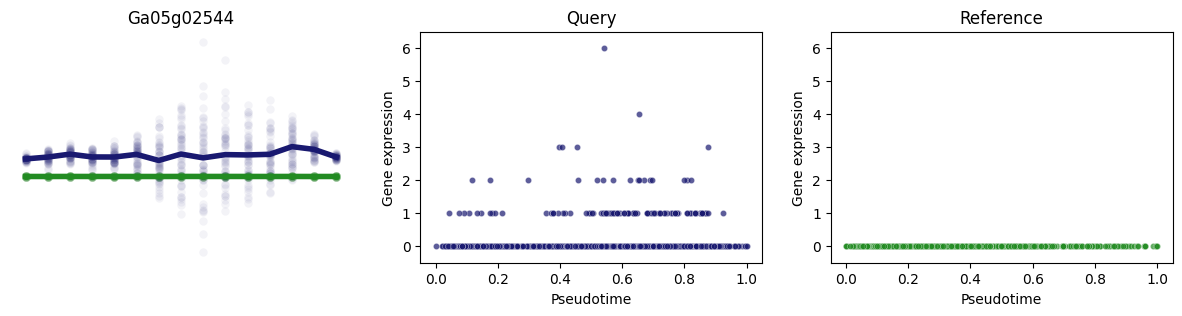

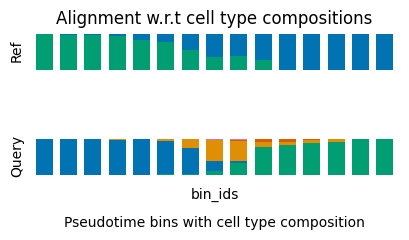

In [28]:
topDEgenes = df[df['alignment_similarity_percentage'] <= threshold_similarity]['Gene']
# print(topDEgenes); print(len(topDEgenes))
#可以做一个enrich看最不相似的基因主要富集到什么功能
os.makedirs("topDEgenes", exist_ok=True)
with open('topDEgenes/topDEgenes.txt', 'w') as f:
    for gene in topDEgenes[:n_top]:
        print(f"Processing gene: {gene}")
        gene_obj = aligner.results_map[gene]
        alignment_str = gene_obj.alignment_str
        f.write(f'{gene} {alignment_str}\n')
        # 1) 打印对齐字符串和彩色版本
        print(alignment_str)
        print(VisualUtils.color_al_str(alignment_str))
        print()
        print(gene_obj.al_visual)
        # 2) 画 alignment landscape
        gene_obj.landscape_obj.plot_alignment_landscape()
        plt.savefig(
            f'topDEgenes/plot_cost_{gene}_{prefix_ref}_vs_{prefix_query}.pdf',
            bbox_inches='tight'
        )
        plt.show()
        plt.close('all')
        # 3) 画 time series（带细胞）
        VisualUtils.plotTimeSeries(gene, aligner, plot_cells=True)
        plt.savefig(
            f'topDEgenes/plotTimeSeries_{gene}_{prefix_ref}_vs_{prefix_query}.pdf',
            bbox_inches='tight'
        )
        plt.show()
        plt.close('all')
        #VisualUtils.show_gene_alignment(gene, aligner, adata_ref, adata_query, annotation_colname, joint_cmap2)
        VisualUtils.visualize_gene_alignment(gene_obj, adata_ref, adata_query, annotation_colname, cmap=joint_cmap2)
        plt.savefig(
            f'topDEgenes/gene_alignment_{gene}_{prefix_ref}_vs_{prefix_query}.pdf',
            bbox_inches='tight'
        )
        plt.show()
        # plt.show()
        plt.close('all')

## Clustering alignments 

Running experiment to determine the distance threshold for alignment clusters from hierarchical clustering. We aim to select a locally optimal threshold that gives a good trade-off between high mean Silhouette score and low number of clusters which can be biologically meaningful. 

----------------------------3. Clustering alignments ---------------------
Compute distance matrix
- using levenshtein distance metric
Experimental mode: exploring different thresholds


 78%|███████▊  | 77/99 [11:54<03:24,  9.27s/it]


-- Cluster diagnostic plots
Potential candidates for distance threshold: a locally optimal thresholds that gives a good trade-off between high mean Silhouette score and low number of clusters 


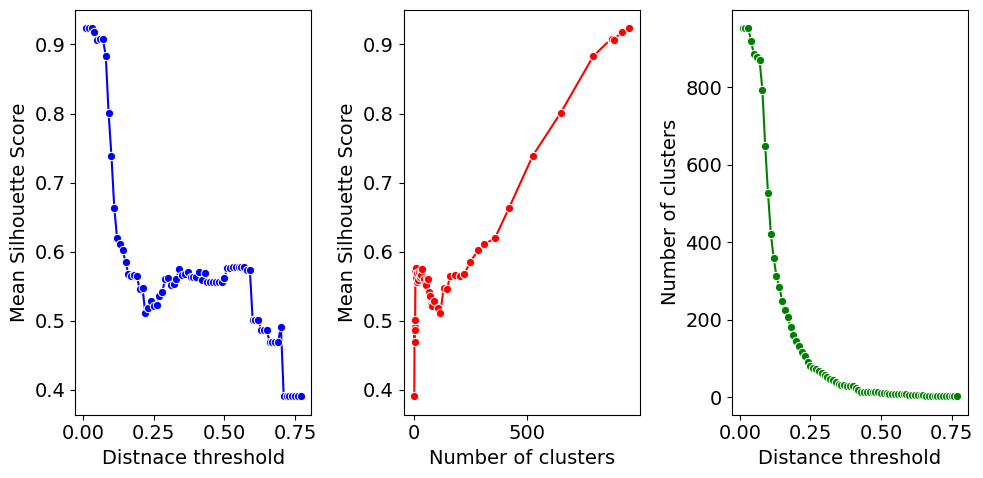

In [30]:
# ClusterUtils.run_clustering(aligner, metric='levenshtein', DIST_THRESHOLD=0.37) 
print('----------------------------3. Clustering alignments ---------------------')
df = ClusterUtils.run_clustering(aligner, metric='levenshtein', experiment_mode=True)
plt.savefig(f'clustering_genes_{prefix_ref}_vs_{prefix_query}.pdf', bbox_inches='tight')

Run clustering with the chosen distance threshold. In this case we select 0.37

In [31]:
plt.close('all')

Visualise gene alignment grouped together in each cluster <br>
Note: diagonals represent matches; vertical and horizontal paths could represent either warp matches or indels (mismatches)

Compute distance matrix
- using levenshtein distance metric
run agglomerative clustering | distance threshold = 0.57
silhouette_score:  0.5774107659061374
Cluster ID | Number of genes in the cluster


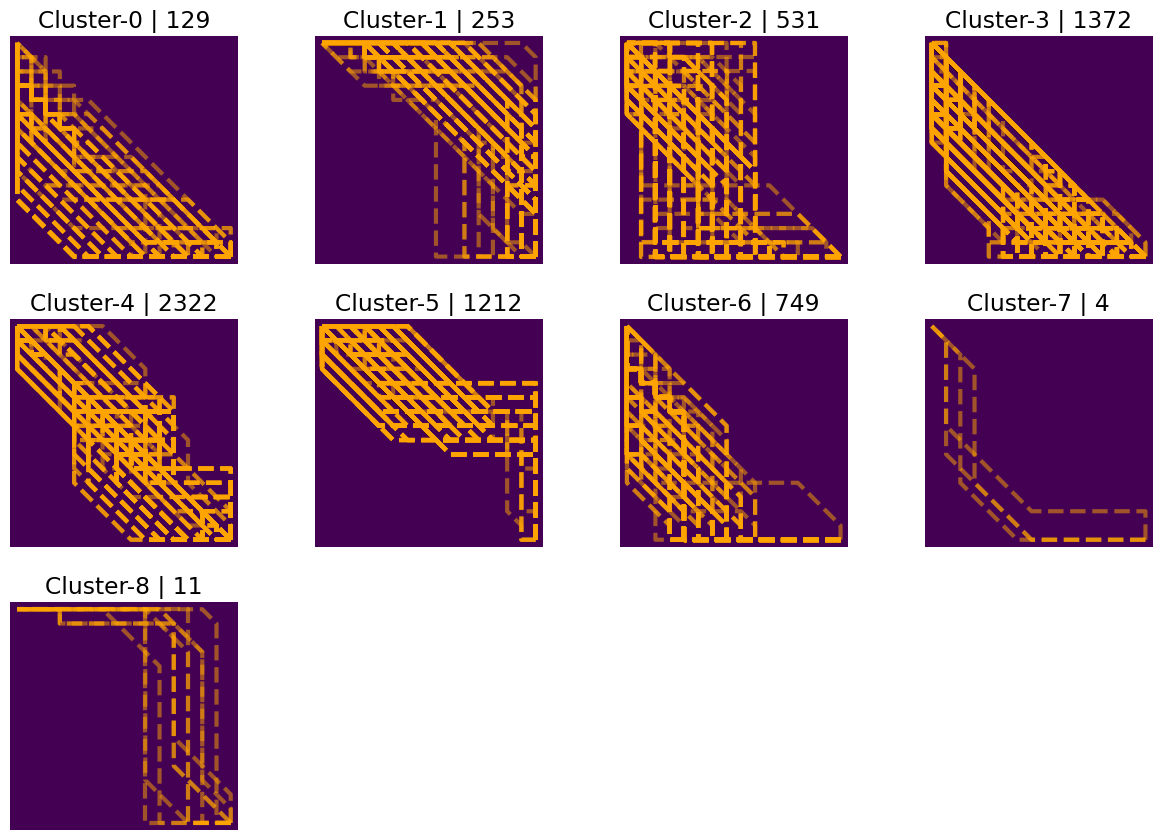

In [32]:
ClusterUtils.run_clustering(aligner, metric='levenshtein', DIST_THRESHOLD=distance_threshold)
ClusterUtils.visualise_clusters(aligner,n_cols = 4, figsize= (5,3))
plt.savefig(f'clustering_genes_{distance_threshold}_{prefix_ref}_vs_{prefix_query}.pdf', bbox_inches='tight')

Visualise the distance matrix used in the clustering 

In [33]:
plt.close('all')

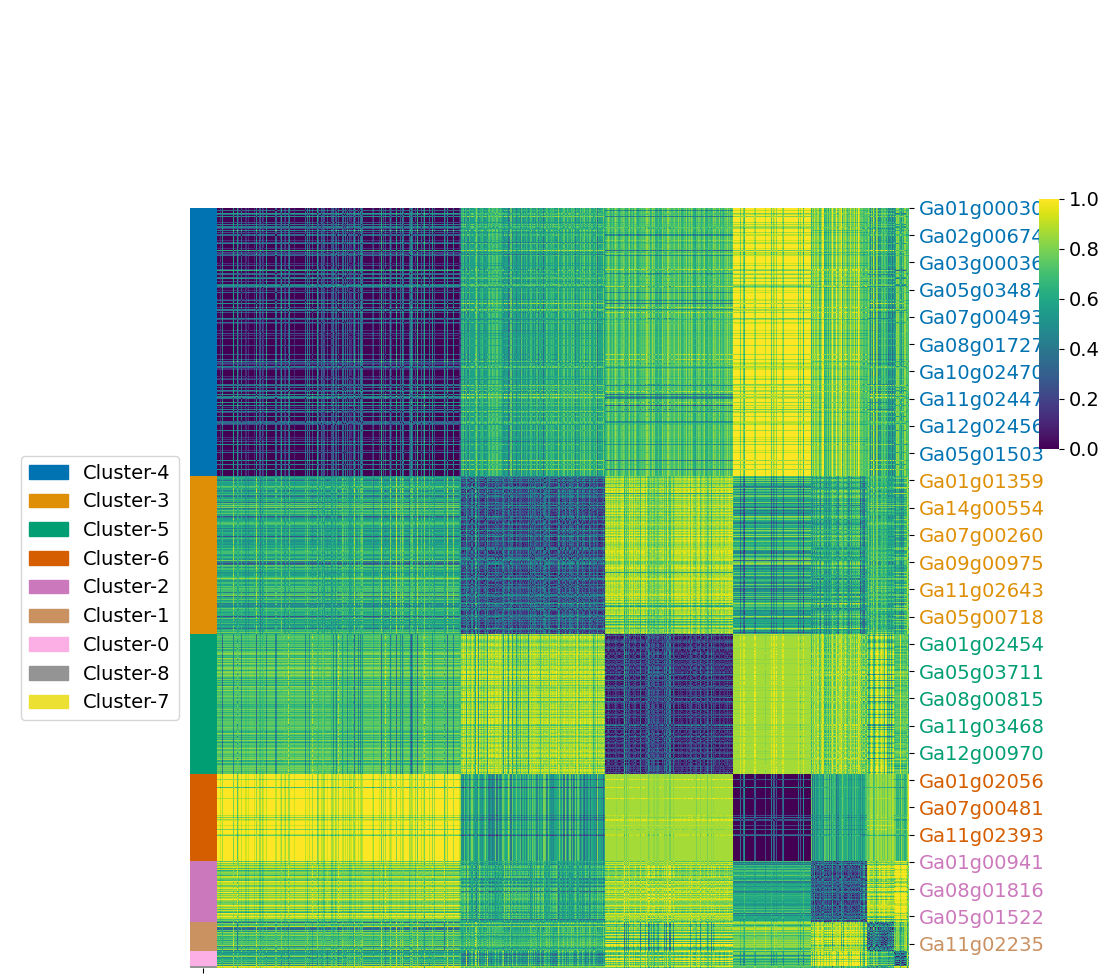

In [34]:
VisualUtils.plot_distmap_with_clusters(aligner)
plt.savefig(
    f'clustering_distmap_{distance_threshold}_{prefix_ref}_vs_{prefix_query}.png',
    bbox_inches='tight',
    dpi=72          # 清晰度够用且文件小；再降可改成 100 或 72
)

In [35]:
plt.close('all')

In [36]:
# ClusterUtils.print_cluster_average_alignments(aligner)
def get_cluster_average_alignments(aligner, gene_set, deterministic=True):
            cluster_alobjs = []
            for g in gene_set:
                cluster_alobjs.append(aligner.results_map[g])
            i = aligner.results[0].fwd_DP.T_len
            j = aligner.results[0].fwd_DP.S_len
            avg_alignment = ''
            tracked_path = []
            tracked_path.append([i,j])
            while(True):
                if(i==0 and j==0):
                    break
                backtrack_states_probs = {}
                backtrack_states_probs['M'] = 0 
                backtrack_states_probs['W'] = 0 
                backtrack_states_probs['V'] = 0 
                backtrack_states_probs['D'] = 0 
                backtrack_states_probs['I'] = 0 
                # record the count of each state at this [i,j] cell across all alignments 
                for a in cluster_alobjs:
                    backtract_state = a.landscape_obj.L_matrix_states[i,j]
                    if(backtract_state=='0'):
                        backtrack_states_probs['M']+=1 
                    elif(backtract_state=='1'):
                        backtrack_states_probs['W']+=1 
                    elif(backtract_state=='2'):
                        backtrack_states_probs['V']+=1 
                    elif(backtract_state=='3'):
                        backtrack_states_probs['D']+=1 
                    elif(backtract_state=='4'):
                        backtrack_states_probs['I']+=1 
                # compute the proportion of the state for the [i,j] cell
                for state in backtrack_states_probs.keys(): 
                    backtrack_states_probs[state] = backtrack_states_probs[state]/len(cluster_alobjs) 
                if(deterministic):
                    # take the most probable state based on max frequent state of this [i,j] cell
                    cs = np.argmax(np.asarray(list(backtrack_states_probs.values())) )
                else:
                    # sample a state from the state frequency distribution
                    cs = Utils.sample_state(np.asarray(list(backtrack_states_probs.values()) ) )
                if(cs==0):
                    i = i-1
                    j = j-1
                    avg_alignment = 'M' + avg_alignment 
                elif(cs==1 or cs==3):
                    j= j-1
                    if(cs==1):
                        avg_alignment = 'W' + avg_alignment
                    else:
                        avg_alignment = 'D' + avg_alignment
                elif(cs==2 or cs==4):
                    i=i-1
                    if(cs==2):
                        avg_alignment = 'V' + avg_alignment
                    else:
                        avg_alignment = 'I' + avg_alignment
                tracked_path.append([i,j])
            return avg_alignment, tracked_path

def print_cluster_average_alignments(aligner):
    aligner.gene_clusters_average_alignments = {}
    for i in range(len(aligner.gene_clusters)):
        average_alignment, avg_path =  get_cluster_average_alignments(aligner, aligner.gene_clusters[i] )
        print('cluster: ', i, average_alignment, '(',len(aligner.gene_clusters[i]), 'genes)')
        aligner.gene_clusters_average_alignments[i] = average_alignment


print_cluster_average_alignments(aligner)

# # To access the genes in a particular cluster
# cluster_id = 0
# print(aligner.gene_clusters[cluster_id]) 

# # To print all gene alignments in the cluster
# aligner.show_cluster_alignment_strings(cluster_id)

# ---------------- Clustering genes with df -----
records = []
for cluster_id, gene_list in aligner.gene_clusters.items():
    for gene in gene_list:
        gene_obj   = aligner.results_map[gene]
        alignment  = gene_obj.alignment_str
        records.append({
            'gene': gene,
            'cluster': cluster_id,
            'alignment': alignment
        })

df = pd.DataFrame(records)      # 三列：gene、cluster、alignment
print(df.head())
df.to_csv('gene_cluster_alignment.csv', sep='\t', index=False)

cluster:  0 IIIIIIIMMMMMMMWWIWWWWWW ( 129 genes)
cluster:  1 IDDDDDDDMMMMMMMIIMIVVV ( 253 genes)
cluster:  2 MIVVMMVVMVDVVVVIDDDDDDDDDD ( 531 genes)
cluster:  3 IIIDIIVMMMMMMMMIDDDDDD ( 1372 genes)
cluster:  4 MMMMMMMMMMMMMMM ( 2322 genes)
cluster:  5 MMMMMMWWWWWIWWWWIIIIIIII ( 1212 genes)
cluster:  6 IIIDIDIDIDIIIIIIIIIDDDDDDDDDDD ( 749 genes)
cluster:  7 MMIIMVVVVVVDDMMMMWWWWWW ( 4 genes)
cluster:  8 IIIDIDIDIDIIIIIIIIIDDDDDDDDDDD ( 11 genes)
         gene  cluster                alignment
0  Ga01g00013        3    MMIIIIIMMMMMMMIDDDDDD
1  Ga01g00062        3    IIIIMMMMMMMMMIDIDDDDD
2  Ga01g00123        3  MVVVVVVMMMMMMIDIDDDDDDD
3  Ga01g00248        3   IIIDIIMMMMMMMMIIDDDDDD
4  Ga01g00223        3     MIIIIMMMMMMDDDDDMMMI


Print the aggregate (average) cell-level alignments for each cluster

In [37]:
ClusterUtils.print_cluster_average_alignments(aligner)

cluster:  0 IIIIIIIMMMMMMMWWIWWWWWW ( 129 genes)
cluster:  1 IDDDDDDDMMMMMMMIIMIVVV ( 253 genes)
cluster:  2 MIVVMMVVMVDVVVVIDDDDDDDDDD ( 531 genes)
cluster:  3 IIIDIIVMMMMMMMMIDDDDDD ( 1372 genes)
cluster:  4 MMMMMMMMMMMMMMM ( 2322 genes)
cluster:  5 MMMMMMWWWWWIWWWWIIIIIIII ( 1212 genes)
cluster:  6 IIIDIDIDIDIIIIIIIIIDDDDDDDDDDD ( 749 genes)
cluster:  7 MMIIMVVVVVVDDMMMMWWWWWW ( 4 genes)
cluster:  8 IIIDIDIDIDIIIIIIIIIDDDDDDDDDDD ( 11 genes)


In [38]:
# # To access the genes in a particular cluster
# cluster_id = 0
# print(aligner.gene_clusters[cluster_id]) 

# # To print all gene alignments in the cluster
# aligner.show_cluster_alignment_strings(cluster_id)

Subset: 3
Average Alignment:  IIIDIIVMMMMMMMMIDDDDDD (cell-level)


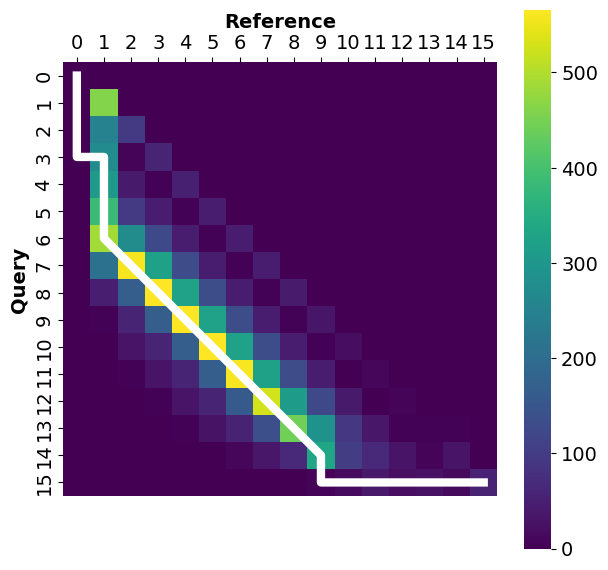

Subset: 0
Average Alignment:  IIIIIIIMMMMMMMWWIWWWWWW (cell-level)


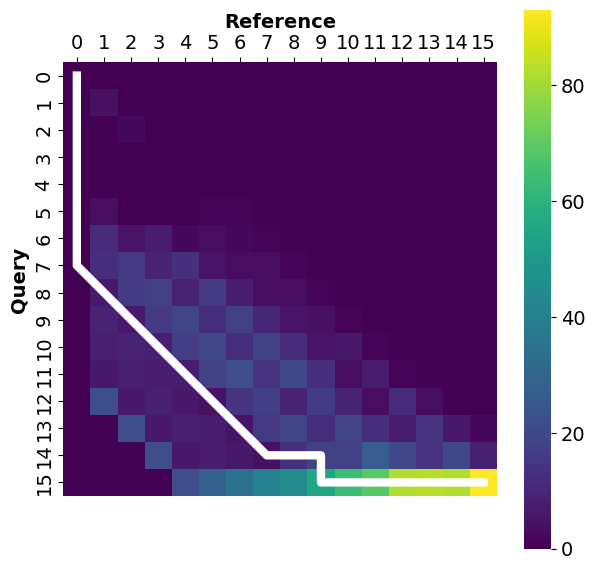

Subset: 6
Average Alignment:  IIIDIDIDIDIIIIIIIIIDDDDDDDDDDD (cell-level)


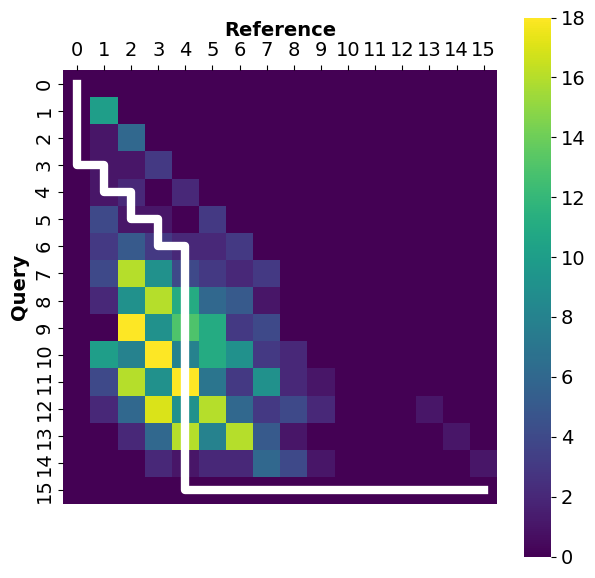

Subset: 4
Average Alignment:  MMMMMMMMMMMMMMM (cell-level)


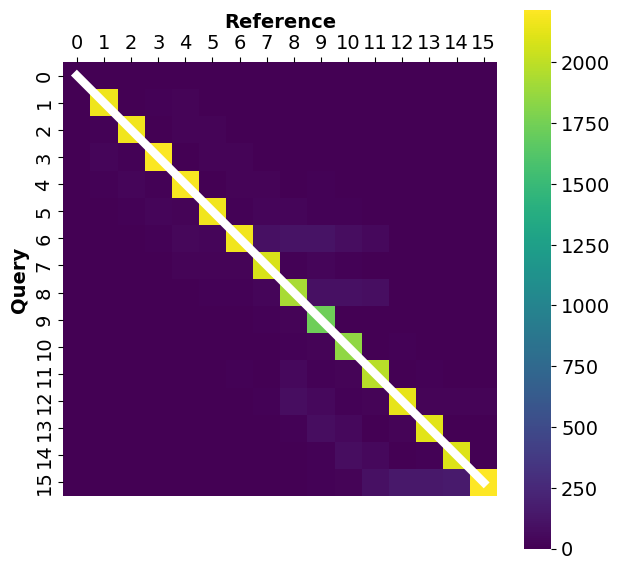

Subset: 2
Average Alignment:  MIVVMMVVMVDVVVVIDDDDDDDDDD (cell-level)


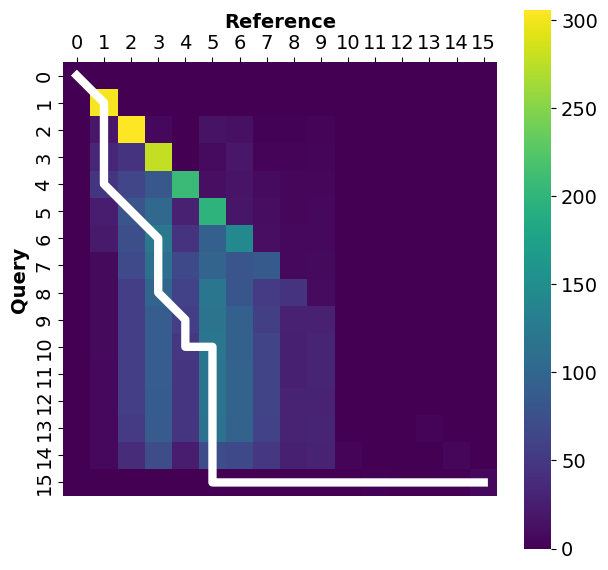

Subset: 5
Average Alignment:  MMMMMMWWWWWIWWWWIIIIIIII (cell-level)


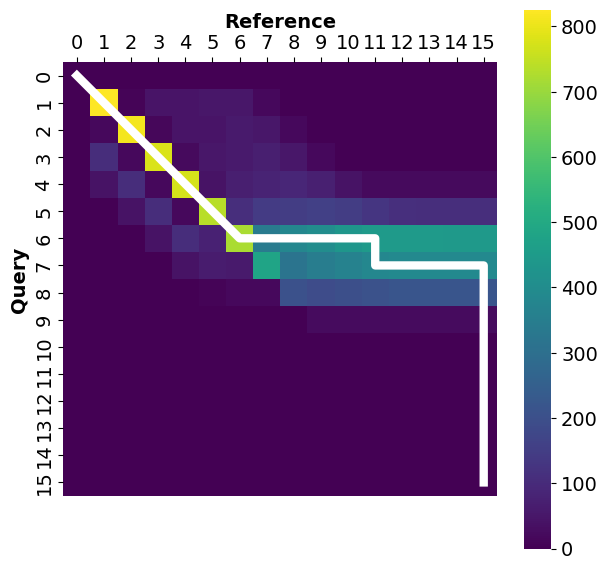

Subset: 1
Average Alignment:  IDDDDDDDMMMMMMMIIMIVVV (cell-level)


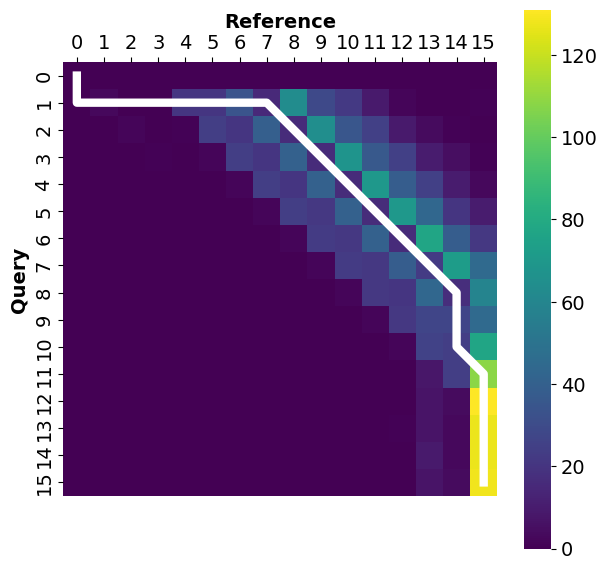

Subset: 8
Average Alignment:  IIIDIDIDIDIIIIIIIIIDDDDDDDDDDD (cell-level)


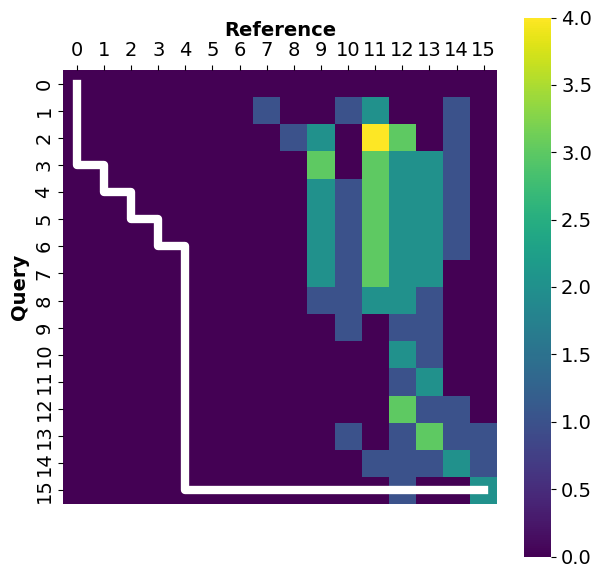

Subset: 7
Average Alignment:  MMIIMVVVVVVDDMMMMWWWWWW (cell-level)


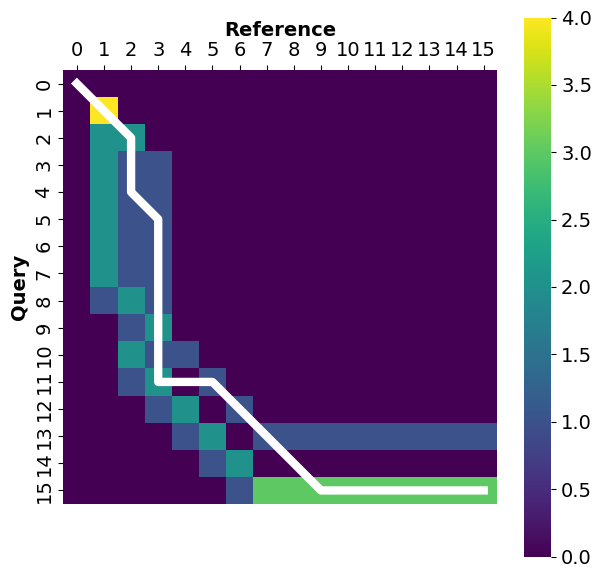

In [39]:
# ------------------ subset ------
os.makedirs("cluster", exist_ok=True)
for cluster in df['cluster'].unique():
    print(f"Subset: {cluster}")
    GENE_SUBSET = df[df['cluster'] == cluster]['gene']
    # Average alignment of any given subset of genes
    aligner.get_aggregate_alignment_for_subset(GENE_SUBSET)
    plt.savefig(
        f'cluster/aggregate_alignment_{cluster}_{prefix_ref}_vs_{prefix_query}.pdf',
        bbox_inches='tight'
    )
    plt.show()
    plt.close('all')

In [40]:
# # To get the cluster id of an alignment object, e.g. TNF, 
# aligner.results_map['Ga01g01085'].cluster_id

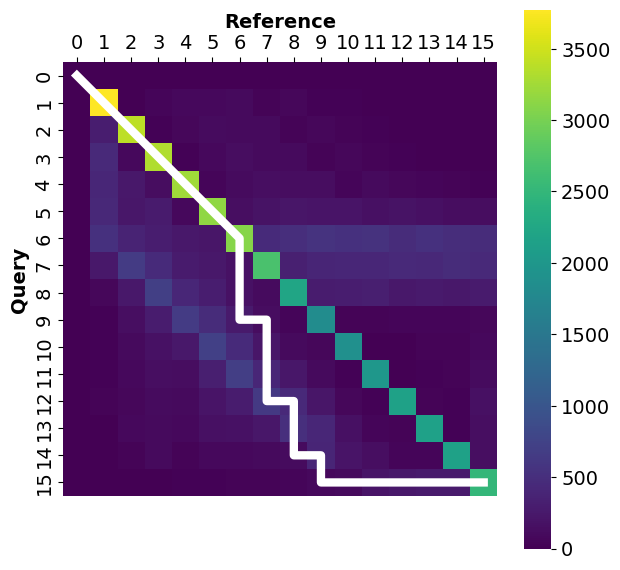

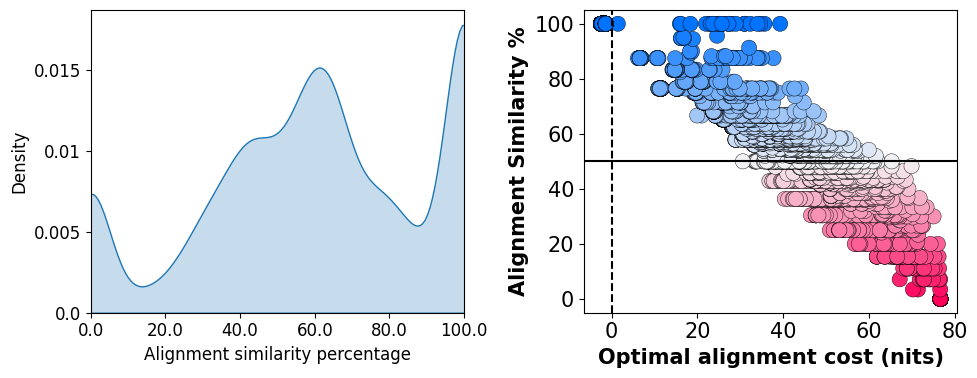

In [41]:
# ----------------------- Save log.txt ---------------------
import sys
from contextlib import redirect_stdout

# 打开一个追加模式文件
log_file = open('log.txt', 'a', buffering=1)  # buffering=1 行缓冲，实时写盘
with redirect_stdout(log_file):
    aligner.get_aggregate_alignment()
    print()
    df = aligner.get_stat_df()
    print()
    print_cluster_average_alignments(aligner)
    


log_file.close()

In [42]:
# ---------------------- How to save aligner file? -------------
import pickle

with open(f'aligner_{prefix_ref}_vs_{prefix_query}.pkl', 'wb') as f:
    pickle.dump(aligner, f)
    
# with open('aligner.pkl', 'rb') as f:
#     aligner = pickle.load(f)

### Average alignment of any given subset of genes 
e.g. `gene_list[40:60]` or a specific gene set in a specific pathway, e.g. EMT

In [52]:
# GENE_SUBSET = gene_list[40:60]
# aligner.get_aggregate_alignment_for_subset(GENE_SUBSET)

###  Exploring alignment and trends of a given gene set

Following calls a wrapper to extract a specified pathway gene set from msigdb database via blitzgsea package (https://github.com/MaayanLab/blitzgsea) 

In [ ]:
# IGS = PathwayAnalyser.InterestingGeneSets(gene_list) 
# #IGS.get_available_pathway_list('KEGG_2021_Human')
# #IGS.get_available_pathway_list('MSigDB_Hallmark_2020')

You could also add a new library by calling below. <br>

In [ ]:
# ===== Check available libraries in enrichr

#import blitzgsea
#blitzgsea.enrichr.print_libraries()

# ===== Add a selected library

#library_name = "GO_Molecular_Function_2021"
#IGS.add_library(blitzgsea.enrichr.get_library(library_name), library_name)

#### Check the aggregate alignment and interpolated gene expression trends for a given pathway gene set as below. 

In [ ]:
# IGS.add_new_set_from_msigdb('MSigDB_Hallmark_2020', 'Epithelial Mesenchymal Transition', user_setname='EMT') 

In [ ]:
# PathwayAnalyser.get_pathway_alignment_stat(aligner, IGS.SETS['EMT'], 'EMT', cluster=True, FIGSIZE=(3,6))

In [ ]:
# PathwayAnalyser.get_pathway_alignment_stat(aligner, gene_list[0:20], 'EMT', cluster=True, FIGSIZE=(3,6))